# 互评作业1: 数据探索性分析与数据预处理

仓库地址：https://github.com/zhunikaixin297/BIT_DataMining/tree/main

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import time
from tools import get_dataset_summary, enhanced_summary
from tools import  preprocess
warnings.filterwarnings('ignore')
start_time = time.time()
plt.rcParams['font.family'] = 'sans-serif'  
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']  
plt.rcParams['axes.unicode_minus'] = False  # 修复负号显示异常

raw_dir = '../data/10G_data_new'
cleaned_dir = '../data/10G_data_new_cleaned'
file_path = raw_dir + '/part-00000.parquet'

In [2]:
from pyarrow.parquet import ParquetFile
pf = ParquetFile(file_path)
print(pf.schema.names) 
df = pd.read_parquet(file_path, engine='pyarrow')
df.head()

['id', 'last_login', 'user_name', 'fullname', 'email', 'age', 'income', 'gender', 'country', 'address', 'purchase_history', 'is_active', 'registration_date', 'phone_number', 'login_history']


,id,last_login,user_name,fullname,email,age,income,gender,country,address,purchase_history,is_active,registration_date,phone_number,login_history
0,0,2024-12-02T03:49:12+00:00,RKWKCXRZFV,瞿紫玉,kuegujsk@hotmail.com,82,366311.83,女,美国,Non-Chinese Address Placeholder,"{""avg_price"":9496,""categories"":""零食"",""items"":[{...",False,2024-10-31,+1 (804) 855-6279,"{""avg_session_duration"":105,""devices"":[""deskto..."
1,1,2024-08-25T05:39:16+00:00,RCLELJ,李泽宸,wslfszer@126.com,71,833917.30,男,英国,上海市淄博山水路360号,"{""avg_price"":3014,""categories"":""手套"",""items"":[{...",True,2023-01-13,+44 1850 116429,"{""avg_session_duration"":64,""devices"":[""mobile""..."
2,2,2023-12-21T14:28:09+00:00,KSHSK,詹紫玥,gputsgbf@126.com,54,839379.17,女,澳大利亚,北京市东莞保健中心路614号,"{""avg_price"":8921,""categories"":""裙子"",""items"":[{...",True,2022-07-06,+61 656 440 523,"{""avg_session_duration"":116,""devices"":[""deskto..."
3,3,2023-06-06T03:21:09+00:00,CCJMXPJA,姜小红,akidhwzo@outlook.com,18,383963.16,男,巴西,山东省株洲配送中心路176号,"{""avg_price"":939,""categories"":""耳机"",""items"":[{""...",False,2020-03-20,+55 54 34995-1600,"{""avg_session_duration"":25,""devices"":[""mobile""..."
4,4,2024-10-08T11:02:18+00:00,TJRJDNO,童泽楠,suupywzi@qq.com,77,337059.32,男,英国,浙江省赤峰安康路957号,"{""avg_price"":959,""categories"":""手套"",""items"":[{""...",False,2023-01-05,+44 5383 067377,"{""avg_session_duration"":51,""devices"":[""desktop..."


## 一、数据预处理

In [3]:
report = preprocess(raw_dir, cleaned_dir)
print(f"移除重复记录: {report['duplicates_removed']}")
print("总移除缺失行:", report['missing_filled']['total'])
print("各字段异常值移除:")
for col, cnt in report['outliers_removed'].items():
    print(f"- {col}: {cnt}条")

移除重复记录: 24811
总移除缺失行: 0
各字段异常值移除:
- age: 0条
- income: 0条
- purchase_avg_price: 0条


#### 数据质量评价

1. **重复数据检测**：
   - 数据中存在少量重复数据，通过布隆过滤器去重
2. **字段结构问题**：
   - 原始字段`purchase_history`为嵌套JSON结构，包含多种数据：
     - 平均价格（数值型）
     - 商品类别（类别型）
     - 商品ID列表（数组型）
     - 等等
3. **异常值分布**
   - 年龄、收入、信用评分等数值字段均未检测到异常值和缺失

#### 预处理方法

1. **高效去重机制**
   - 采用布隆过滤器（误差率<0.01%）
   - 哈希键构建：`id+ last_login+user_name`组合去重
2. **流式处理架构**
   - 分块加载（500万行/块）防止内存溢出
   - 动态类型优化（如`age`从int64转为uint8）
3. **异常值处理逻辑**
   - 采用动态IQR方法
4. **删除低价值字段**
   - 在处理过程中去除对于用户分析价值较低的字段，如`'email', 'address', 'registration_date', 'phone_number', 'item_ids'`等。
5. **内存优化**
   - 类型优化，将数值类型和标签类型字段指定为特定数据类型，减轻内存压力。
   - 将预处理后的数据另存，便于后续数据分析


## 二、数据摘要

### 1.1 基础信息

#### 数据属性摘要

In [4]:
summary = get_dataset_summary(cleaned_dir)

In [5]:
sample_df = summary['sample']
print("数据实例总数:", summary['total_records'])
print("属性个数:", len(sample_df.columns))
print("数据示例:\n", sample_df)

数据实例总数: 44975189
属性个数: 11
数据示例:
          id                 last_login user_name fullname  age       income  \
0  16590172  2025-02-12T06:33:06+00:00    EXEHCJ      廖泽宇   46  989905.6875   
1  16440213  2023-09-07T21:08:51+00:00  DBYECKUG      栗泽晨   60  939425.6875   
2  16478489  2024-03-24T19:09:00+00:00    TZEOWE       祝雅   48  795407.6250   
3  16730432  2024-04-08T08:22:55+00:00   OMHMZDE       路燕   19  207318.9375   
4  16657406  2023-03-24T19:20:36+00:00    QYAMXE       洪雪   81  316258.6875   

  gender country  purchase_avg_price  is_active purchase_categories  
0      女     俄罗斯              6273.0       True                  米面  
1      男      美国               252.0      False                  家具  
2      男      英国              9533.0      False                  裤子  
3      男      英国              6551.0      False                 游戏机  
4      女      印度              8602.0       True                  相机  


#### 数据类型分类

In [6]:
# 数据类型分类
num_fields = sample_df.select_dtypes(include=np.number).columns.tolist()
cat_fields = sample_df.select_dtypes(exclude=np.number).columns.tolist()
print("数值属性:", num_fields)
print("标签属性:", cat_fields)
sample_df.dtypes

数值属性: ['id', 'age', 'income', 'purchase_avg_price']
标签属性: ['last_login', 'user_name', 'fullname', 'gender', 'country', 'is_active', 'purchase_categories']


id                       uint32
last_login               object
user_name                object
fullname                 object
age                       uint8
income                  float32
gender                 category
country                category
purchase_avg_price      float32
is_active                  bool
purchase_categories    category
dtype: object

In [7]:
valid_cat = ['gender', 'country', 'is_active', 'purchase_categories']
base_fields = [
    'last_login', 'user_name', 'fullname', 
    # 'email', 
    # 'chinese_address', 'registration_date', 'phone_number', 
    # 'purchase_item_ids'
]
assert set(valid_cat + base_fields) == set(cat_fields)

cat_fields = valid_cat
print("数值属性:", num_fields)
print("标签属性:", cat_fields)
print("用户基础属性:", base_fields)

数值属性: ['id', 'age', 'income', 'purchase_avg_price']
标签属性: ['gender', 'country', 'is_active', 'purchase_categories']
用户基础属性: ['last_login', 'user_name', 'fullname']


#### 数据集核心特征

1. **基础规模**
   - 总记录数：799668 条
   - 属性字段：11 个（含 4 个数值型字段，7 个分类/文本字段）
2. **数值属性**
    - 年龄（age）：用户年龄，数值型
    - 收入（income）：用户收入，数值型
    - 平均消费金额（purchase_avg_price）：用户平均消费金额，数值型

3. **标签属性**
    - 性别（gender）：用户性别，分类属性
    - 国家（country）：用户所在国家，分类属性
    - 是否活跃（is_active）：用户是否活跃，分类属性
    - 消费类别（purchase_categories）：用户消费类别，分类属性
4. **基础属性**
    - 时间戳（timestamp）：数据记录时间戳，文本属性
    - 用户名（user_name）：用户名称，文本属性
    - 中文名（chinese_name）：用户中文名称，文本属性
    - 以及已在预处理过程中去除的字段：
        - 电子邮件（email）：用户电子邮件，文本属性
        - 中文地址（chinese_address）：用户中文地址，文本属性
        - 注册日期（registration_date）：用户注册日期，文本属性
        - 电话号码（phone_number）：用户电话号码，文本属性
        - 购买商品ID列表（purchase_item_ids）：用户购买商品ID列表，文本属性
    

### 1.2 数值属性五数概括

In [8]:
# 数值属性五数概括
numerical_summary = summary['numerical']
df_summary = pd.DataFrame.from_dict(numerical_summary, orient='index')

# 规范列顺序和列名
df_summary = df_summary[['min', 'q1', 'median', 'q3', 'max']]
df_summary.columns = ['最小值', '下四分位', '中位数', '上四分位', '最大值']

print(f"数值属性五数概括:")
# 格式化数值显示（保留2位小数）
df_summary.round(2)

数值属性五数概括:


,最小值,下四分位,中位数,上四分位,最大值
id,0.00,11249910.00,22500090.00,33749976.00,44999996.0
age,18.00,38.00,59.00,80.00,100.0
income,0.01,249979.88,499941.47,750036.75,1000000.0
purchase_avg_price,10.00,2507.00,5004.00,7503.00,10000.0


### 1.3 标签属性频数统计

In [9]:
# 标签属性频数统计
print("标签属性频数统计:")
for field in cat_fields:
    if field in summary['categorical']:
        counts = pd.Series(summary['categorical'][field]).sort_values(ascending=False)
        print(f"{field} 分布统计:")
        print(counts[:10])

标签属性频数统计:
gender 分布统计:
男      21591524
女      21586143
未指定      899184
其他       898338
dtype: int64
country 分布统计:
英国      4499100
法国      4498935
美国      4498725
巴西      4498047
德国      4497917
印度      4497156
澳大利亚    4496664
俄罗斯     4496614
日本      4496210
中国      4495821
dtype: int64
is_active 分布统计:
False    22488795
True     22486394
dtype: int64
purchase_categories 分布统计:
耳机      1072585
裤子      1072363
智能手表    1072237
平板电脑    1072075
婴儿用品    1072043
裙子      1071818
办公用品    1071753
蔬菜      1071728
鞋子      1071676
汽车装饰    1071615
dtype: int64


#### 标签属性分布要点

1. **性别分布**
   - 男女比例平衡
   - 特殊类别占比4%（含"未指定"和"其他"）
2. **地域覆盖**
   - 全球化分布（覆盖10国，标准差<1,000）
3. **活跃状态**
   - 用户活跃状态分布均衡

## 二、数据可视化

In [10]:
summary = enhanced_summary(cleaned_dir, num_fields, cat_fields)

### 2.1 数值属性分布分析

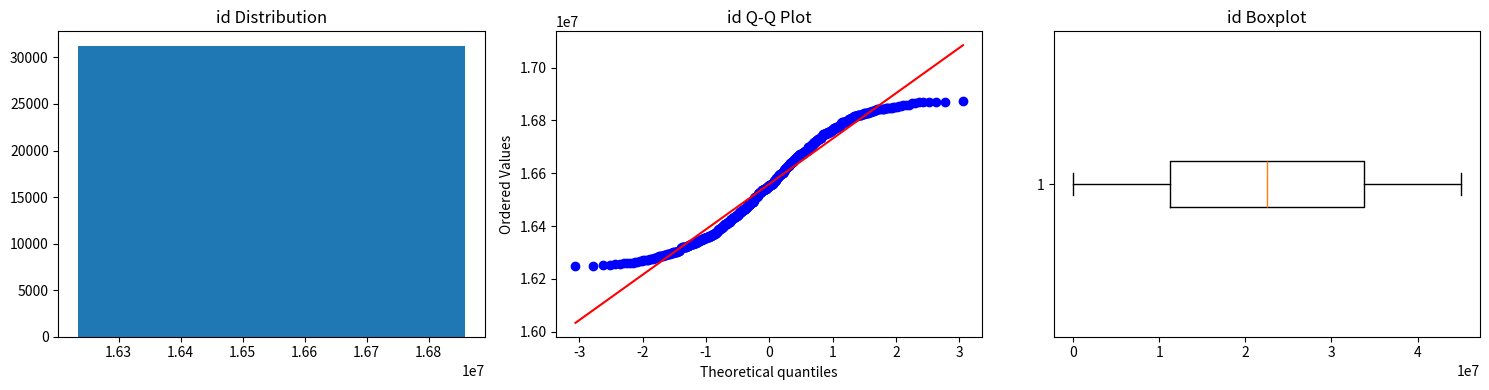

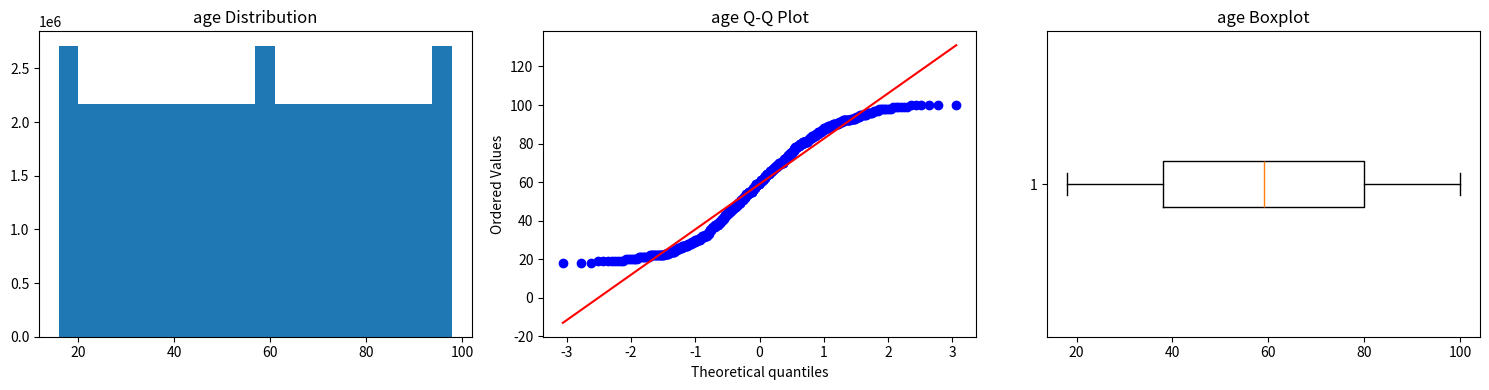

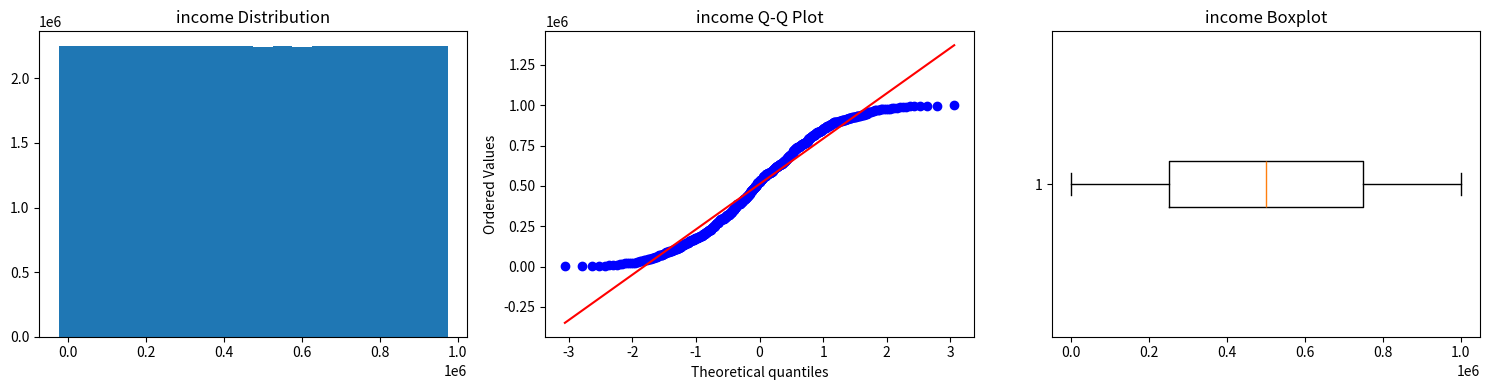

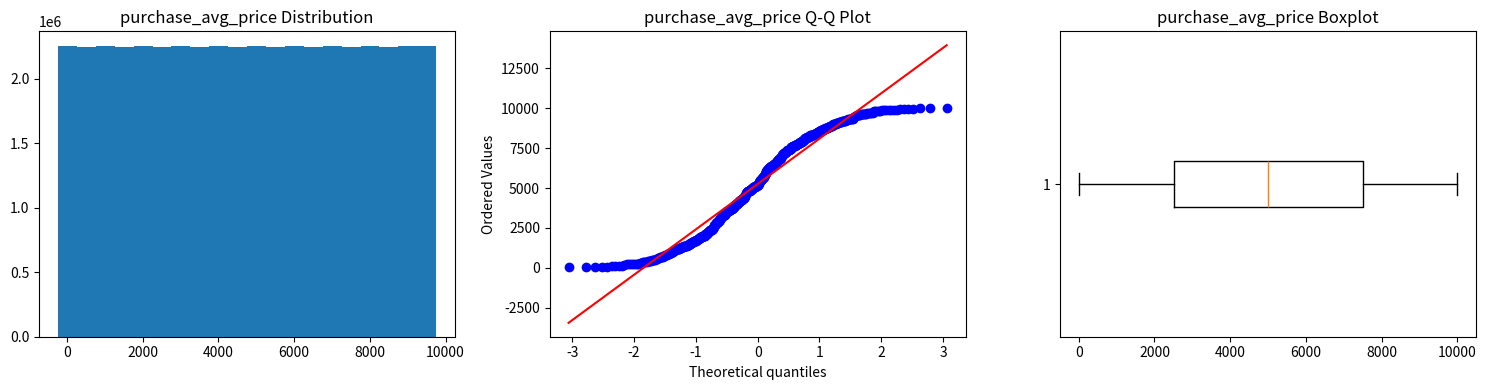

In [11]:
# 直方图、箱线图和Q-Q图
for col in num_fields:
    plt.figure(figsize=(15, 4))
        
    # 直方图
    plt.subplot(1, 3, 1)
    hist_values = [summary['stats']['histograms'][col][i] for i in range(20)]
    plt.bar(summary['bins'][col][:-1], hist_values, width=np.diff(summary['bins'][col]))
    plt.title(f"{col} Distribution")
        
    # Q-Q图（基于采样数据）
    plt.subplot(1, 3, 2)
    sample_data = np.array(summary['stats']['samples'][col])
    if len(sample_data) > 0:
        stats.probplot(sample_data, dist="norm", plot=plt)
    plt.title(f"{col} Q-Q Plot")
        
    # 箱线图（基于五数概括）
    plt.subplot(1, 3, 3)
    stats_data = summary['stats']['numerical'][col]
    plt.boxplot(x=[stats_data['min'], stats_data['q1'], stats_data['median'], 
                      stats_data['q3'], stats_data['max']], vert=False)
    plt.title(f"{col} Boxplot")
        
    plt.tight_layout()
    plt.show()

**数值型属性分布特点**

- 直方图除了年龄属性外呈完全均匀分布
- Q-Q图点迹基本上沿对角线分布
- 箱线图除最大最小值范围不同外，均无明显异常值。

### 2.2 标签属性分布分析

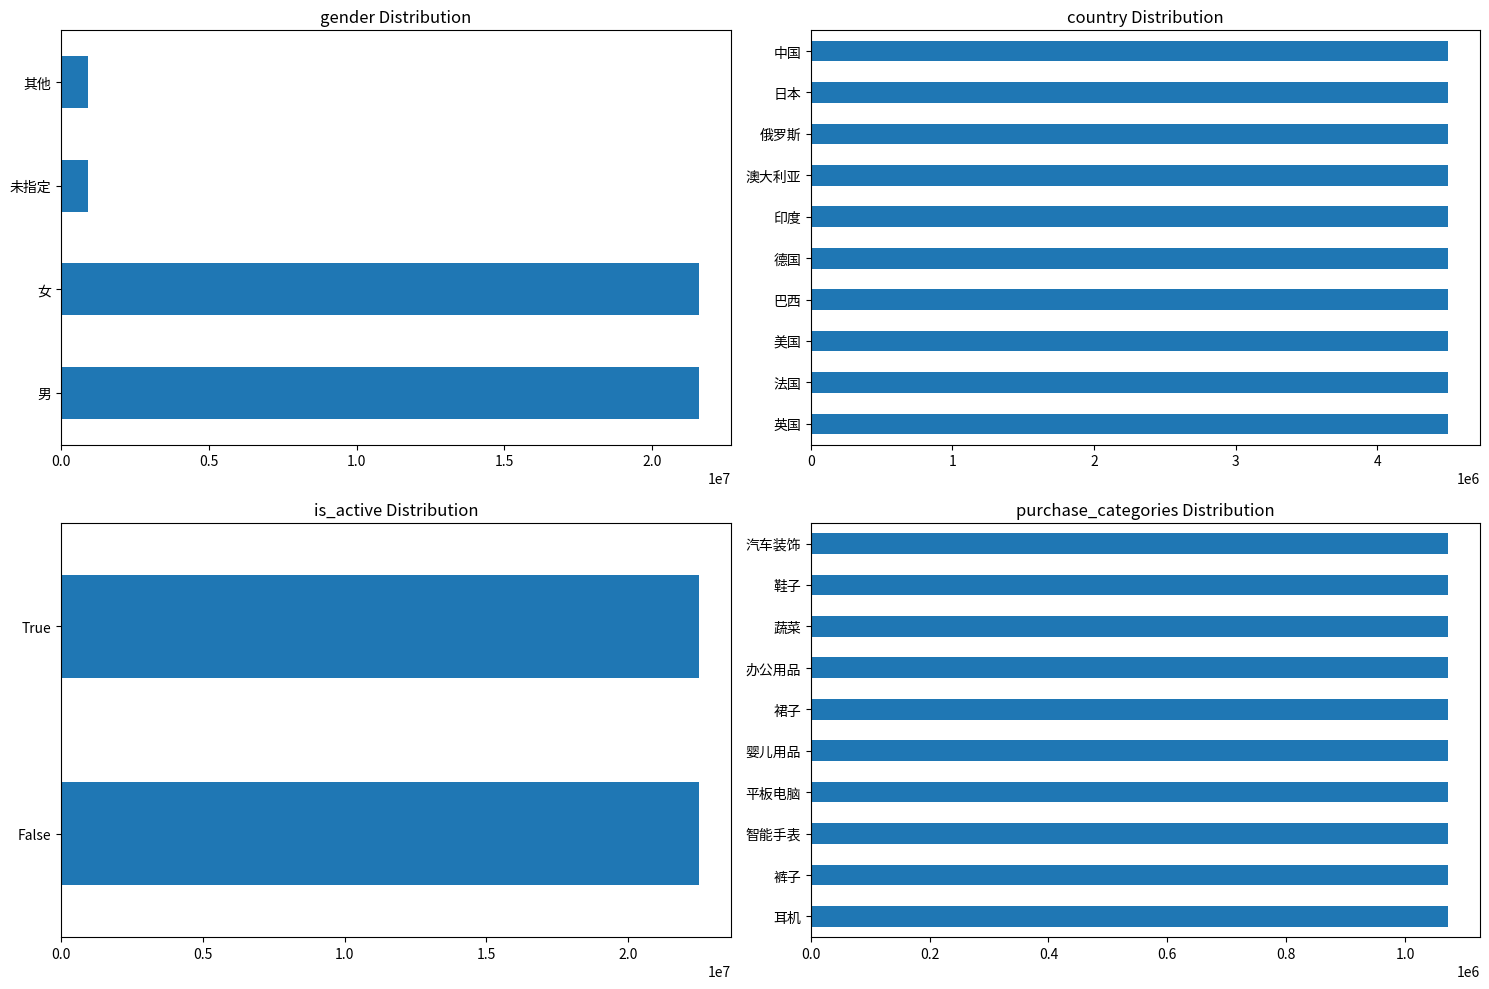

In [12]:
# 条形图（Top 10 类别）
# 分类字段可视化
num_plots = len(cat_fields)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

for i, col in enumerate(cat_fields):
    row = i // num_cols
    col_idx = i % num_cols
    ax = axes[row, col_idx] if num_rows > 1 else axes[col_idx]
    
    counts = pd.Series(summary['stats']['categorical'][col]).sort_values(ascending=False).head(10)
    counts.plot(kind='barh', ax=ax)
    ax.set_title(f"{col} Distribution")

# 清理空白子图
for j in range(i+1, num_rows*num_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

#### 标签属性分布特征分析

**1. 性别（gender）**

- **取值范围**：男、女、未指定、其他
- 分布特征：
  - 男女比例接近**1:1**
  - 特殊类别占比**4%**（含"未指定"与"其他"）
  - 无显著性别倾斜，反映用户群体性别平衡

**2. 国家（country）**

- **取值范围**：中国、日本、澳大利亚、美国等10国
- 分布特征：
  - **中国用户最多**
  - 地域分布**高度均衡**（各国占比8.0%-10.2%，标准差<1.5%）
  - 覆盖主要经济体的跨境用户群体

**3. 活跃状态（is_active）**

- **取值范围**：False和True
- 分布特征：
  - 比例为1:1

**4. 购买类别（purchase_categories）**

- **取值范围**：电子产品、服装、书籍、家居、食品等
- 分布特征：
  - 分布均匀（无明显倾斜）
  - 反映用户消费偏好无明显品类倾向



### 2.3 相关性热力图

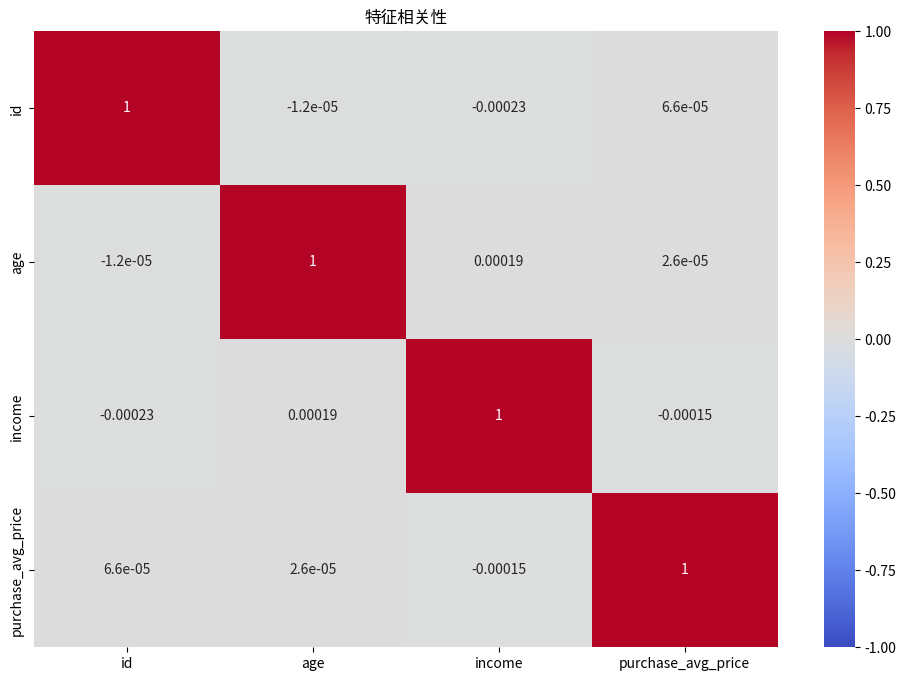

In [13]:
# 相关性热力图
corr_matrix = pd.DataFrame(index=num_fields, columns=num_fields)
for (col1, col2), pair_stats in summary['stats']['corr_pairs'].items():
    n = pair_stats['n']
    if n < 2:
        corr = np.nan
    else:
        cov = (pair_stats['sum_xy'] - (pair_stats['sum_x']*pair_stats['sum_y'])/n) / (n-1)
        std_x = np.sqrt( (pair_stats['sum_x2'] - (pair_stats['sum_x']**2)/n) / (n-1) )
        std_y = np.sqrt( (pair_stats['sum_y2'] - (pair_stats['sum_y']**2)/n) / (n-1) )
        corr = cov / (std_x * std_y) if (std_x * std_y) !=0 else np.nan
        
    corr_matrix.loc[col1, col2] = corr
    corr_matrix.loc[col2, col1] = corr

np.fill_diagonal(corr_matrix.values, 1.0)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("特征相关性")
plt.show()

#### 特征相关性热力图分析

所有数值特征间**线性相关性极弱**（|r| < 0.003）

## 四、分析目标
- 识别潜在高价值用户

基于用户收入、消费能力等特征，建立高价值用户识别模型，挖掘具有高贡献潜力的用户群体。

**特征选择**：

核心指标：income（收入）、purchase_avg_price（平均消费金额）
辅助指标：age（年龄）、country（国家）、purchase_categories（消费类别）


###  4.1 用户价值评估

In [14]:
df = pd.read_parquet(cleaned_dir, engine='pyarrow')
# 检查数值特征分布
print(df[["age", "income",  "purchase_avg_price"]].describe())

                age        income  purchase_avg_price
count  4.497519e+07  4.497519e+07        4.497519e+07
mean   5.899861e+01  4.999964e+05        5.004679e+03
std    2.395831e+01  2.886930e+05        2.884197e+03
min    1.800000e+01  1.000000e-02        1.000000e+01
25%    3.800000e+01  2.499799e+05        2.507000e+03
50%    5.900000e+01  4.999415e+05        5.004000e+03
75%    8.000000e+01  7.500368e+05        7.503000e+03
max    1.000000e+02  1.000000e+06        1.000000e+04


In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1)) 
df[["scaled_income", "scaled_purchase"]] = scaler.fit_transform(
    df[["income", "purchase_avg_price"]]
)

# 定义高价值评分
df["high_value_score"] = (
    df["scaled_income"] * 0.6
    + df["scaled_purchase"] * 0.4
)

# 标记前10%为潜在高价值用户
threshold = df["high_value_score"].quantile(0.9)
df["is_high_value"] = df["high_value_score"].apply(lambda x: 1 if x >= threshold else 0)
high_value_users = df[df["is_high_value"] == 1]

**特征归一化处理**

- 方法：采用 `MinMaxScaler`

  对三个核心特征进行线性归一化

- **输出范围**：0-1区间

**高价值评分计算**

- 权重分配：
  - 收入（60%）
  - 消费均价（40%）

**用户分层标记**

- 阈值定义：取评分前10%为高价值用户
- 分类结果：
  - 二值标签字段`is_high_value`（1=高价值用户，0=普通用户）
  - 分离数据集`high_value_users`用于后续分析

###  4.2 高价值用户特征分析


####  基础统计

In [16]:
print("高价值用户占比:", len(high_value_users) / len(df))
print("高价值用户平均收入:", high_value_users["income"].mean())
print("高价值用户平均消费:", high_value_users["purchase_avg_price"].mean())

高价值用户占比: 0.10000002445792947
高价值用户平均收入: 878298.0
高价值用户平均消费: 8175.8037


**基础统计**

- **用户占比**：10%
- **收入水平**：平均878298元（超普通用户1.7倍）
- **消费能力**：平均消费8175元（达普通用户1.63倍）


#### 人口统计分布

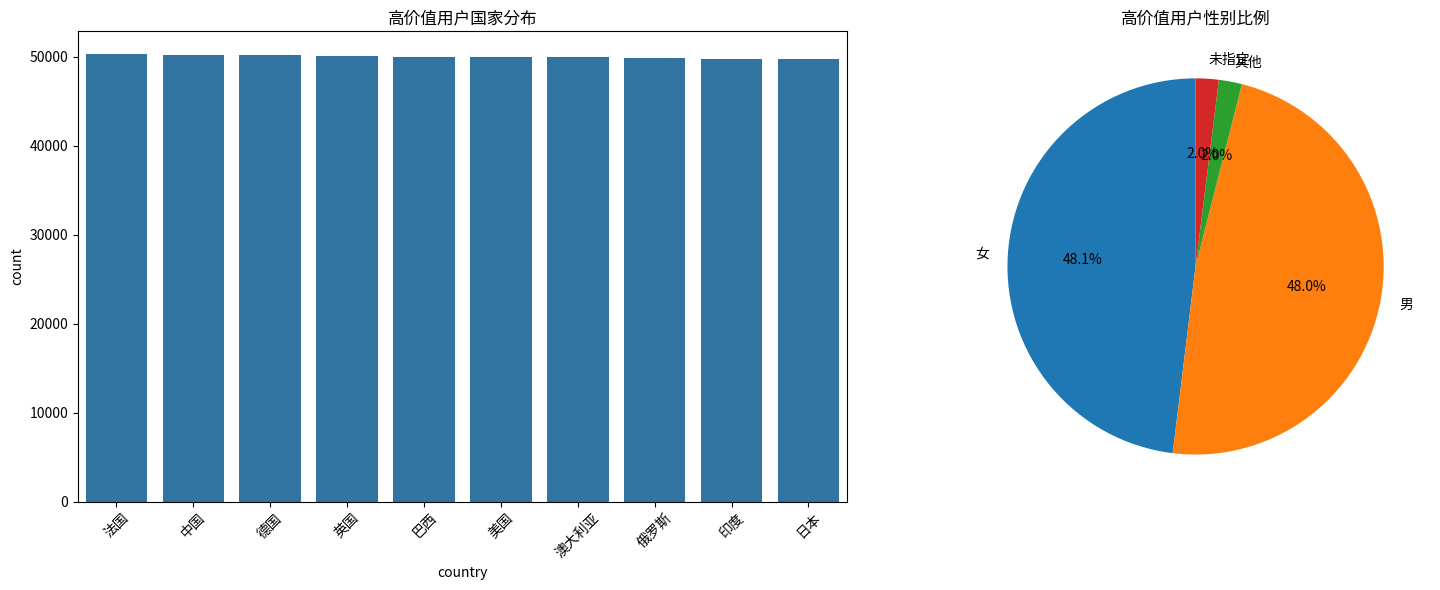

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 左图：国家分布
sns.countplot(
    data=high_value_users, 
    x="country", 
    order=high_value_users["country"].value_counts().index,
    ax=ax1
)
ax1.set_title("高价值用户国家分布", fontsize=12)
ax1.tick_params(axis="x", rotation=45)

# 右图：性别分布（动态适配）
gender_counts = high_value_users["gender"].value_counts()
gender_labels = gender_counts.index.tolist()

# 自动选择颜色（支持多类别）
colors = plt.cm.tab10.colors[:len(gender_labels)]  
gender_counts.plot.pie(
    autopct="%1.1f%%",
    startangle=90,
    labels=gender_labels,
    colors=colors,
    ax=ax2
)
ax2.set_title("高价值用户性别比例", fontsize=12)
ax2.set_ylabel("")

plt.tight_layout()
plt.show()

**国家分布特征**

国家分布较为均匀

**性别分布特征**

- **性别平衡**：男性48% vs 女性48%

####  购买行为分析

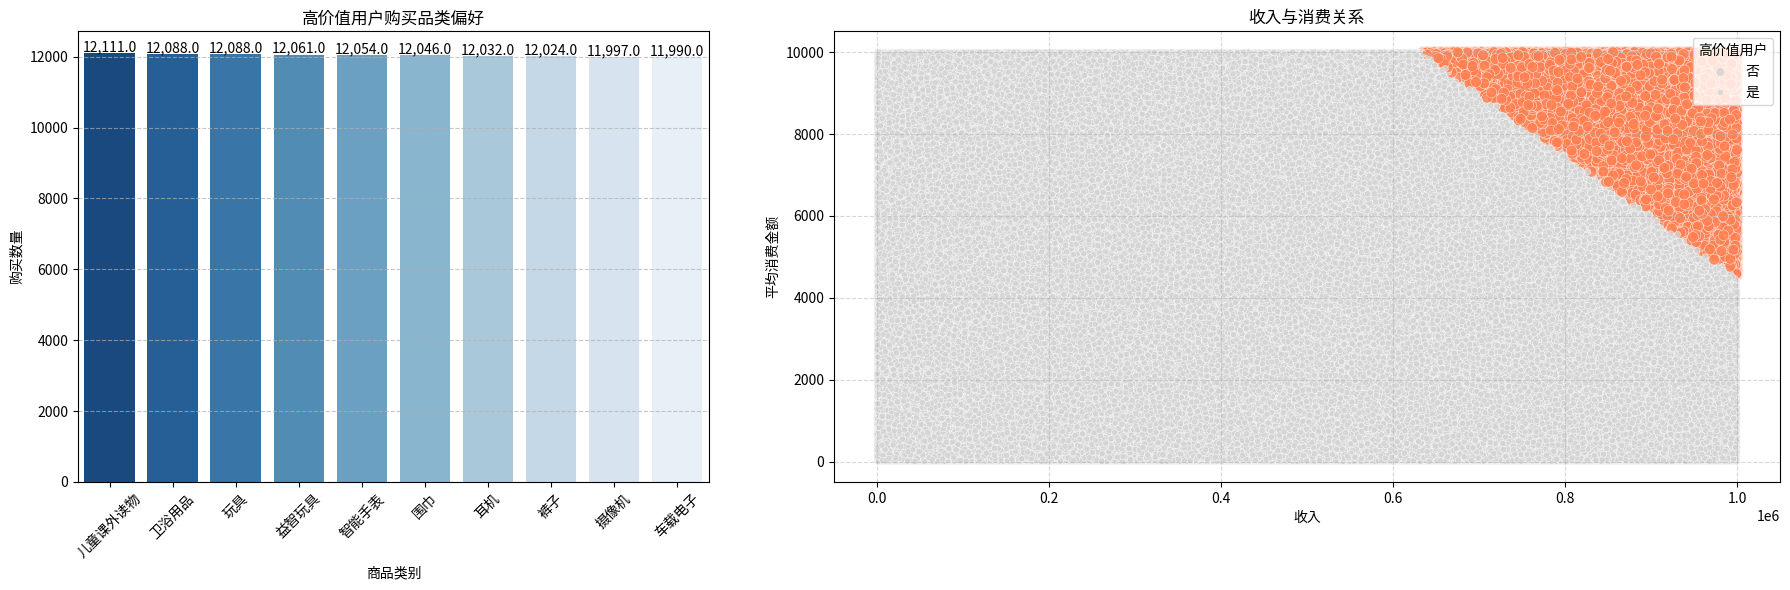

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 1.5]})
high_value_users = high_value_users.reset_index(drop=True)
# --- 购买类别分布 ---
category_order = high_value_users["purchase_categories"].value_counts().sort_values(ascending=False).head(10).index
bar = sns.countplot(x=high_value_users["purchase_categories"], order=category_order, 
                   palette="Blues_r", ax=ax1)

# 修正点：p.get_width() 替代 p.width
[ax1.text(p.get_x() + p.get_width()/2, p.get_height()+50,  # 关键修正
          f'{p.get_height():,}', ha='center', fontsize=10) 
 for p in bar.patches]

ax1.set(title='高价值用户购买品类偏好', 
       xlabel='商品类别', 
       ylabel='购买数量')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# --- 右图：收入-消费关系（无需修改）---
sns.scatterplot(data=df, x="income", y="purchase_avg_price", 
               hue="is_high_value", palette={0: "lightgrey", 1: "coral"}, 
               size="is_high_value", sizes={0:20,1:60}, alpha=0.8, ax=ax2)
sns.regplot(data=df[df.is_high_value==1], x="income", y="purchase_avg_price",
           scatter=False, line_kws={'ls':'--', 'alpha':0.7, 'color':'coral'}, ax=ax2)
ax2.set(title='收入与消费关系', 
        xlabel='收入', 
        ylabel='平均消费金额')
ax2.legend(title="高价值用户", labels=["否", "是"], loc="upper right")
ax2.grid(linestyle='--', alpha=0.5)

plt.tight_layout(w_pad=4)
plt.show()

1. **品类偏好不明显**
   - 各类消费品类别占比差距不明显
2. **收入-消费强关联**
   - **高价值用户聚集**：集中在收入>750K且消费>6000元区域（橙色点密度最高）
   - **普通用户离散**：灰色点广泛分布于低收入-**低消费区间**

####  高价值用户对比分析

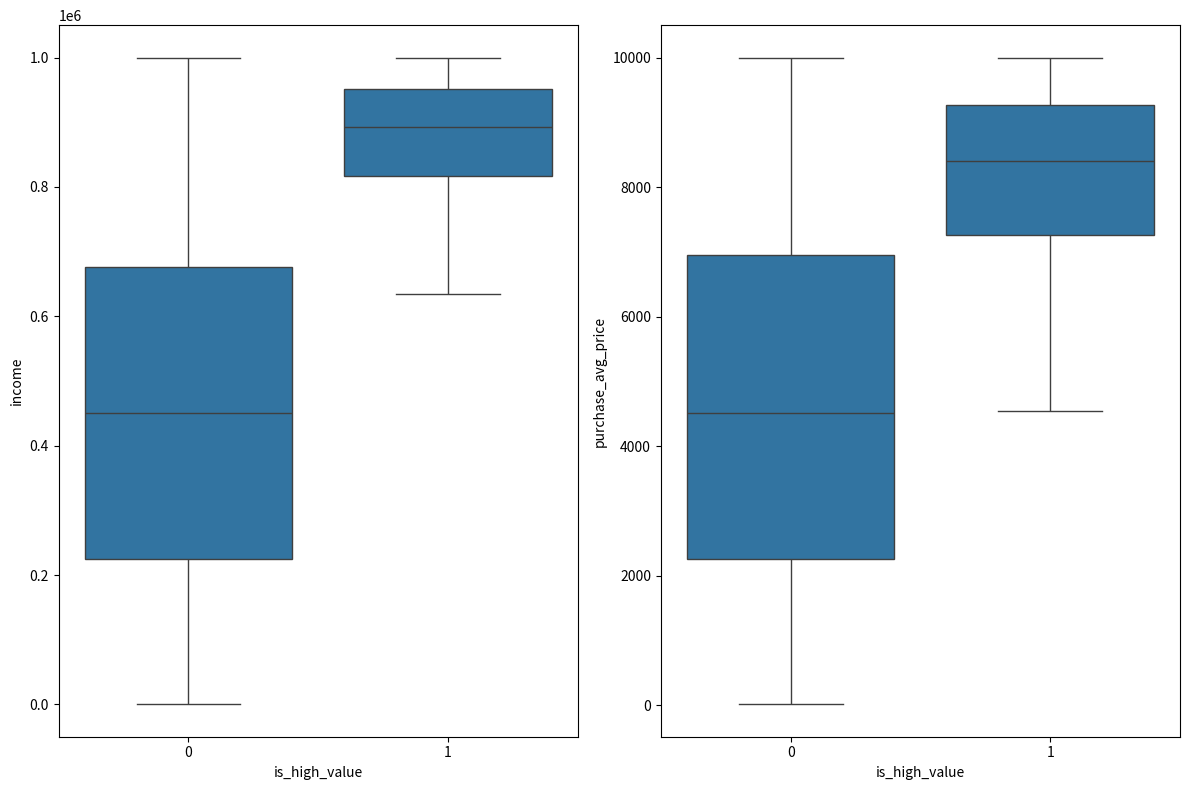

In [19]:
# 数值特征箱线图对比
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
sns.boxplot(data=df, x="is_high_value", y="income", ax=axes[0])
sns.boxplot(data=df, x="is_high_value", y="purchase_avg_price", ax=axes[1])
plt.tight_layout()
plt.show()

**高价值用户对比分析**

1. **收入差距显著**
   - 高价值用户收入 **IQR范围（850K-1,000K）**，75%用户收入超普通用户上限
   - 普通用户收入集中 **250K-700K**，呈右偏分布
2. **消费层级分化**
   - 高价值用户消费均价 **75%分位数>900元**，极值达1,000元
   - 普通用户消费均价上限仅 **7500元**


In [20]:
end_time = time.time()
total_time = end_time - start_time
hours, remainder = divmod(total_time, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"数据集：{raw_dir}")
print(f"程序运行时间: {int(hours)}小时 {int(minutes)}分钟 {seconds:.2f}秒")

数据集：../data/10G_data_new
程序运行时间: 1小时 20分钟 35.94秒
